In [1]:
from src.losses import auc
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)
# mnist = torchvision.datasets.FashionMNIST("../data", train=True, download=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### out-of-distribution

In [4]:
from expr.expr_utils import generate_style_dict, KStyledMNISTGenerator, KStyledMNIST

In [5]:
np.random.seed(101)
torch.manual_seed(101)

In [6]:
style_fns = [
    corruptions.identity,
    corruptions.stripe,
    corruptions.zigzag,
    corruptions.canny_edges,
    lambda x: corruptions.scale(x, 5),
    corruptions.brightness,
]
K = 3


In [7]:
mnist = torchvision.datasets.MNIST("../data", train=True)
mnist_train, mnist_test = random_split(mnist, [50000, 10000])
style_dict = generate_style_dict(
    classes=list(range(10)), styles=list(range(len(style_fns))), k=K
)
mnist_generator = KStyledMNISTGenerator(mnist_train, style_fns, style_dict, "train")
train = KStyledMNIST(
    mnist_generator,
    transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
)
mnist_generator = KStyledMNISTGenerator(mnist_test, style_fns, style_dict, "test")
test = KStyledMNIST(
    mnist_generator,
    transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
)
train, valid = random_split(train, [0.85, 0.15])

Generating dataset: 100%|██████████| 10000/10000 [00:01<00:00, 5470.32item/s]


In [8]:
style_dict

{0: {'train': array([0, 5, 4]), 'test': array([1, 2, 3])},
 1: {'train': array([2, 5, 3]), 'test': array([0, 1, 4])},
 2: {'train': array([3, 1, 2]), 'test': array([0, 4, 5])},
 3: {'train': array([3, 5, 2]), 'test': array([0, 1, 4])},
 4: {'train': array([1, 0, 2]), 'test': array([3, 4, 5])},
 5: {'train': array([4, 5, 2]), 'test': array([0, 1, 3])},
 6: {'train': array([2, 1, 0]), 'test': array([3, 4, 5])},
 7: {'train': array([3, 5, 4]), 'test': array([0, 1, 2])},
 8: {'train': array([1, 0, 2]), 'test': array([3, 4, 5])},
 9: {'train': array([3, 4, 2]), 'test': array([0, 1, 5])}}

### Experiment

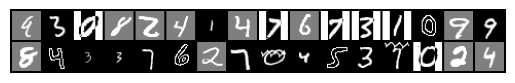

In [9]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)

X, label, style = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


In [10]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)

In [11]:
from src.utils.trainer_utils import get_cnn_trainer, get_clearvae_trainer, get_lamcnn_trainer

In [ ]:
cnn_trainer = get_cnn_trainer(10, device)
cnn_trainer.fit(51, train_loader, valid_loader)

In [42]:
(aps, aucs), acc = cnn_trainer.evaluate(test_loader, False, 0)
print("m_auc:", np.mean(list(aucs.values())).round(3))
print("m_ap:", np.mean(list(aps.values())).round(3))
print("acc:", acc)

m_auc: 0.886
m_ap: 0.538
acc: tensor(0.4812)


In [56]:
lamcnn_trainer = get_lamcnn_trainer(10, device, lam_coef=0.0001)
lamcnn_trainer.fit(31, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 59/59 [00:00<00:00, 546.40it/s]


val_aupr: {0: 0.995, 1: 0.987, 2: 0.971, 3: 0.963, 4: 0.985, 5: 0.968, 6: 0.99, 7: 0.97, 8: 0.965, 9: 0.93}
0.972
val_auroc: {0: 0.999, 1: 0.997, 2: 0.996, 3: 0.995, 4: 0.998, 5: 0.994, 6: 0.999, 7: 0.995, 8: 0.994, 9: 0.99}
0.996
val_acc: 0.922


val-epoch 5: 100%|██████████| 59/59 [00:00<00:00, 559.97it/s]


val_aupr: {0: 1.0, 1: 0.997, 2: 0.996, 3: 0.994, 4: 0.999, 5: 0.994, 6: 0.999, 7: 0.995, 8: 0.996, 9: 0.993}
0.996
val_auroc: {0: 1.0, 1: 0.999, 2: 0.999, 3: 0.999, 4: 1.0, 5: 0.999, 6: 1.0, 7: 0.999, 8: 1.0, 9: 0.999}
0.999
val_acc: 0.975


val-epoch 10: 100%|██████████| 59/59 [00:00<00:00, 546.51it/s]


val_aupr: {0: 1.0, 1: 0.998, 2: 0.997, 3: 0.996, 4: 0.999, 5: 0.996, 6: 0.999, 7: 0.996, 8: 0.998, 9: 0.994}
0.997
val_auroc: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 0.999, 6: 1.0, 7: 1.0, 8: 1.0, 9: 0.999}
1.0
val_acc: 0.978


val-epoch 15: 100%|██████████| 59/59 [00:00<00:00, 591.28it/s]


val_aupr: {0: 1.0, 1: 0.999, 2: 0.997, 3: 0.997, 4: 0.999, 5: 0.997, 6: 0.999, 7: 0.997, 8: 0.998, 9: 0.995}
0.998
val_auroc: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 0.999}
1.0
val_acc: 0.981


val-epoch 20: 100%|██████████| 59/59 [00:00<00:00, 581.46it/s]


val_aupr: {0: 1.0, 1: 0.998, 2: 0.997, 3: 0.997, 4: 0.999, 5: 0.997, 6: 0.999, 7: 0.996, 8: 0.998, 9: 0.995}
0.998
val_auroc: {0: 1.0, 1: 1.0, 2: 0.999, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 0.999}
1.0
val_acc: 0.981


val-epoch 25: 100%|██████████| 59/59 [00:00<00:00, 612.43it/s]


val_aupr: {0: 1.0, 1: 0.998, 2: 0.997, 3: 0.997, 4: 0.999, 5: 0.997, 6: 1.0, 7: 0.997, 8: 0.998, 9: 0.996}
0.998
val_auroc: {0: 1.0, 1: 1.0, 2: 0.999, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 0.999}
1.0
val_acc: 0.981


val-epoch 30: 100%|██████████| 59/59 [00:00<00:00, 580.33it/s]


val_aupr: {0: 1.0, 1: 0.998, 2: 0.997, 3: 0.997, 4: 0.999, 5: 0.997, 6: 0.999, 7: 0.997, 8: 0.998, 9: 0.996}
0.998
val_auroc: {0: 1.0, 1: 1.0, 2: 0.999, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 0.999}
1.0
val_acc: 0.983


In [58]:
(aps, aucs), acc = lamcnn_trainer.evaluate(test_loader, False, 0)
print("m_auc:", np.mean(list(aucs.values())).round(3))
print("m_ap:", np.mean(list(aps.values())).round(3))
print("acc:", acc)

m_auc: 0.911
m_ap: 0.606
acc: tensor(0.5259)


In [ ]:
clear_trainer = get_clearvae_trainer(1/8, True, 5e-4, 16, 100, 0.1, device)
clear_trainer.fit(31, train_loader, valid_loader)

In [19]:
import torch.nn as nn
from src.trainer import DownstreamMLPTrainer

In [ ]:
z_dim = clear_trainer.model.z_dim  # which is 1/2 * total_z_dim
device = clear_trainer.device
# Freeze VAE parameters
for p in clear_trainer.model.parameters():
    p.requires_grad = False

# Create and train MLP classifier
mlp = nn.Sequential(
    nn.Linear(z_dim, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 10),
).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

trainer = DownstreamMLPTrainer(
    clear_trainer.model, mlp, optimizer, criterion, 10, device
)
trainer.fit(11, train_loader, valid_loader)

In [21]:
(aps, aucs), acc = trainer.evaluate(test_loader, False, 0)
print("m_auc:", np.mean(list(aucs.values())).round(3))
print("m_ap:", np.mean(list(aps.values())).round(3))
print("acc:", acc)

m_auc: 0.924
m_ap: 0.687
acc: tensor(0.5901)
